<a href="https://colab.research.google.com/github/bagusjackal/BigData2022/blob/main/TI3E_TugasPYSpark_BigData_Farid_Bagus_Setiawan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 199 kB 49.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=4e6525e476718c65ee748a4df56a658f3645e39ae5a95e0f16de2d730661675b
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [11]:
# Create SparkSession
spark = SparkSession.builder.appName('recommender_system').getOrCreate()

In [20]:
# load the dataset and create sprk dataframe
df=spark.read.csv('/content/drive/MyDrive/Big Data 2022/movie_ratings_df.csv',inferSchema='True',header='True')
# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table
df.limit(3).toPandas()

,userId,title,rating
0,196,Kolya (1996),3
1,63,Kolya (1996),3
2,226,Kolya (1996),5


In [21]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



In [22]:
from pyspark.ml.feature import StringIndexer, IndexToString
stringIndexer = StringIndexer(inputCol='title', outputCol='title_new')
# Applying stringindexer object on dataframe movie title column
model = stringIndexer.fit(df)
#creating new dataframe with transformed values
indexed = model.transform(df)
#validate the numerical title values
indexed.limit(5).toPandas()

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0
3,154,Kolya (1996),3,287.0
4,306,Kolya (1996),5,287.0


In [23]:
# split the data into training and test datatset
train, test = indexed.randomSplit([0.75,0.25])
from pyspark.ml.recommendation import ALS

#Training the recommender model using train datatset
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='userId'
        ,itemCol='title_new'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

#fit the model on train set
rec_model=rec.fit(train)

#making predictions on test set 
predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).toPandas()

,userId,title,rating,title_new,prediction
0,148,Beauty and the Beast (1991),4,114.0,3.280946
1,148,Being There (1979),5,290.0,3.041248
2,148,Cold Comfort Farm (1995),5,262.0,7.940670
3,148,Dr. Strangelove or: How I Learned to Stop Worr...,5,123.0,4.039846
4,148,Free Willy (1993),1,761.0,1.899935


In [24]:
# Importing Regression Evaluator to measure RMSE
from pyspark.ml.evaluation import RegressionEvaluator
# create Regressor evaluator object for measuring accuracy
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating')
# apply the RE on predictions dataframe to calculate RMSE
rmse=evaluator.evaluate(predicted_ratings)
# print RMSE error
print(rmse)

1.022927493559263


In [25]:
# First we need to create dataset of all distinct movies 
unique_movies=indexed.select('title_new').distinct()

#create function to recommend top 'n' movies to any particular user
def top_movies(user_id,n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like 
    
    """
    #assigning alias name 'a' to unique movies df
    a = unique_movies.alias('a')
    
    #creating another dataframe which contains already watched movie by active user 
    watched_movies=indexed.filter(indexed['userId'] == user_id).select('title_new')
    
    #assigning alias name 'b' to watched movies df
    b=watched_movies.alias('b')
    
    #joining both tables on left join 
    total_movies = a.join(b, a.title_new == b.title_new,how='left')
    
    #selecting movies which active user is yet to rate or watch
    remaining_movies=total_movies.where(col("b.title_new").isNull()).select(a.title_new).distinct()
    
    
    #adding new column of user_Id of active useer to remaining movies df 
    remaining_movies=remaining_movies.withColumn("userId",lit(int(user_id)))
    
    
    #making recommendations using ALS recommender model and selecting only top 'n' movies
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)
    
    
    #adding columns of movie titles in recommendations
    movie_title = IndexToString(inputCol="title_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)
    
    #return the recommendations to active user
    return final_recommendations.show(n,False)

In [26]:
# Test: recommend 5 movies for user of id=60
top_movies(60,5)

+---------+------+----------+-----------------------------------------------------------+
|title_new|userId|prediction|title                                                      |
+---------+------+----------+-----------------------------------------------------------+
|928.0    |60    |5.779697  |Paradise Lost: The Child Murders at Robin Hood Hills (1996)|
|1385.0   |60    |5.529337  |Maya Lin: A Strong Clear Vision (1994)                     |
|1288.0   |60    |5.4564877 |Whole Wide World, The (1996)                               |
|1122.0   |60    |5.4017053 |Faithful (1996)                                            |
|915.0    |60    |5.3983274 |Oscar & Lucinda (1997)                                     |
+---------+------+----------+-----------------------------------------------------------+



In [27]:
# Firstly we create sparkSession (like a container)
spark = SparkSession.builder.appName('Play with pyspark ML on titatic_dataset').getOrCreate()
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv('/content/drive/MyDrive/Big Data 2022/train.csv',header = 'True',inferSchema='True')

In [28]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [29]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


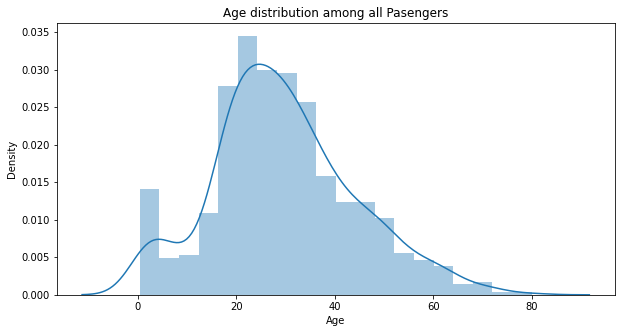

In [30]:
pandas_df = df.toPandas()

plt.figure(figsize=(10,5))
plt.title('Age distribution among all Pasengers')
sns.distplot(pandas_df['Age']);

In [31]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [32]:
# Because Cabin column has a lot missing value ( > 50%) so we can remove it
df = df.drop("Cabin")

In [33]:
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [34]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Checking the average age by Initials
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [35]:
# Assigning missing values in age feature based on average age of Initials
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

In [36]:
# Embarked columns has two missing values, let check it
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [37]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
df = df.na.fill({"Embarked" : 'S'})
# Check again the missing value status
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



In [38]:
df = df.withColumn("Family_Size",col('SibSp')+col('Parch')) # Create new column: Family_size
df = df.withColumn('Alone',lit(0))  # Create new column: Alone and assign 0 default value to Alone column
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))

# converting Sex, Embarked & Initial columns from string to number using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [39]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [40]:
# Now we drop columns that not needed for modelling
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [41]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

In [42]:
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [43]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])
# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

In [44]:
# LOAD PYSPARK LIBRARIES
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# DEFINE ALGORITHM 
lr = LogisticRegression(labelCol="Survived")

# DEFINE GRID PARAMETERS
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# DEFINE CROSS VALIDATION WITH PARAMETERS
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8009708737864077
Precision:  0.7999910973399432


In [45]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


The ROC score is :  0.8599527930763176


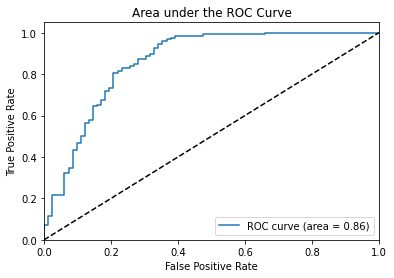

In [46]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()